In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd

import xml.etree.ElementTree as ET
#import gdown
import time
import math
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

from keras.utils import np_utils
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.applications.xception import decode_predictions
%matplotlib inline
from sklearn.metrics import classification_report

from PIL import Image
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
print("Loaded all libraries")

Loaded all libraries


In [24]:
image_path = '/content/drive/MyDrive/ADA_Project/data1/'
num_of_categories = 2
image_size = 224
batch_size = 16

In [27]:
import time
floor_list = sorted(os.listdir(image_path))

num_classes = len(floor_list)
print("{} floor_classes".format(num_classes))

2 floor_classes


In [28]:
# Define a time counter function to test the algorythms performance 
_start_time = time.time()

def process_time_starts():
    global _start_time 
    _start_time = time.time()

def time_elapsed():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('The process took: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [29]:
%cd /content/drive/MyDrive/ADA_Project/

/content/drive/MyDrive/ADA_Project


In [30]:
%cd data1

/content/drive/MyDrive/ADA_Project/data1


In [31]:
!ls

Clean  Dirty


In [32]:
%cd ..

/content/drive/MyDrive/ADA_Project


In [33]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(floor_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [34]:
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in floor_list:
        base_name = "./data1/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = np_utils.to_categorical(targets, num_classes=num_classes)

In [35]:
class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = cv2.imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.Sometimes(0.5,
                    
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-40, 40),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image

In [36]:
x_train, x_test, y_train, y_test = train_test_split(paths, targets, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

train_ds = ImageGenerator(x_train, y_train, batch_size=32, shape=(image_size, image_size,3), augment=True)
val_ds = ImageGenerator(x_test, y_test, batch_size=32, shape=(image_size, image_size,3), augment=False)
test_ds = ImageGenerator(x_test, y_test, batch_size=32, shape=(image_size, image_size,3), augment=False)

In [37]:

from tensorflow.keras.applications import InceptionV3

base_model = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False, pooling='avg')#Summary of inception Model

base_model.trainable = False


#pre_trained_model.summary()



In [38]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_94 (Conv2D)             (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, None, None,   96         ['conv2d_94[0][0]']              
 ormalization)                  32)                                                    

In [39]:
flat_dim = 5 * 5 * 2048

my_model = Sequential(base_model)

#my_model.add(Flatten())
#my_model.add(Dropout(0.1)) # dropout added
my_model.add(Dense(1032, activation='relu',input_dim=flat_dim))
my_model.add(Dense(512, activation='relu'))
#my_model.add(Dropout(0.1))
my_model.add(Dense(256, activation='relu'))
my_model.add(Dense(2, activation='softmax'))



In [40]:
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense_8 (Dense)             (None, 1032)              2114568   
                                                                 
 dense_9 (Dense)             (None, 512)               528896    
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dense_11 (Dense)            (None, 2)                 514       
                                                                 
Total params: 24,578,090
Trainable params: 2,775,306
Non-trainable params: 21,802,784
_________________________________________________________________


[1e-05, 6.505114555849587e-06, 1.3998974074878144e-05, 2.1158257692363077e-05, 2.6349806140466085e-05, 2.9032781503571898e-05, 2.9396559030789573e-05, 2.7979491786027585e-05, 2.540182222438155e-05, 2.2217993076484613e-05, 1.885603456913674e-05, 1.5609303737669377e-05, 1.265427690063973e-05, 1.0077640616334645e-05, 7.903437440340427e-06, 6.116030942221757e-06, 4.677609611772819e-06, 3.5404805065519026e-06, 2.655051675737932e-06, 1.9745568653868732e-06, 1.457488127964179e-06, 1.068520029068309e-06, 7.785125464502897e-07, 5.640054703120814e-07, 4.0647805168961314e-07]


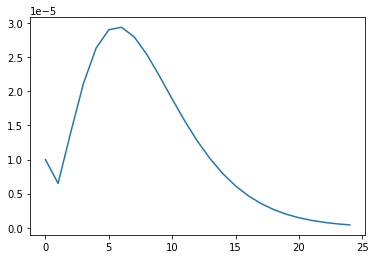

In [41]:
###################
total_epoch = 8
learning_rate_init = 0.00001
###################

def lr_scheduler(epoch):
    epoch += 1
   
    if epoch == 1:
        return learning_rate_init
    
    elif epoch >= 2 and epoch <= 40:
        return (0.2*epoch**3)*math.exp(-0.45*epoch)*learning_rate_init
    
    else:
        return lr_scheduler(40-1)
    

stage = [i for i in range(0,25)]
learning_rate = [lr_scheduler(x) for x in stage]
plt.plot(stage, learning_rate)
print(learning_rate)

In [42]:

# Callbacks

scheduler = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience = 3, mode='max', min_delta=1, verbose=1)

In [43]:
my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
process_time_starts()

hist = my_model.fit_generator(generator=train_ds, steps_per_epoch=40, validation_data=val_ds,  validation_steps=70, epochs=8, callbacks=[scheduler])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until



Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/8
40/40 [==============================] - 505s 13s/step - loss: 0.6159 - accuracy: 0.6706 - val_loss: 0.5220 - val_accuracy: 0.7944 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 6.505114555849587e-06.
Epoch 2/8
40/40 [==============================] - 99s 2s/step - loss: 0.4728 - accuracy: 0.8157 - lr: 6.5051e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.3998974074878144e-05.
Epoch 3/8
40/40 [==============================] - 99s 2s/step - loss: 0.3866 - accuracy: 0.8557 - lr: 1.3999e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.1158257692363077e-05.
Epoch 4/8
40/40 [==============================] - 99s 2s/step - loss: 0.2974 - accuracy: 0.8941 - lr: 2.1158e-05

Epoch 5: LearningRateScheduler setting learning rate to 2.6349806140466085e-05.
Epoch 5/8
40/40 [==============================] - 99s 2s/step - loss: 0.2333 - accuracy: 0.9231 - lr: 2.6350e-05

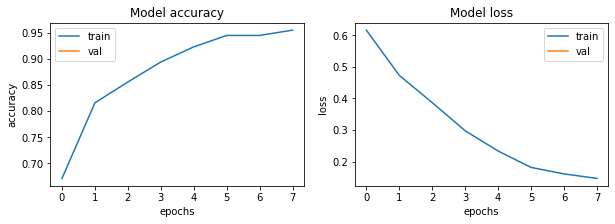

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [46]:
test_loss, test_accuracy = my_model.evaluate_generator(generator=test_ds,steps=int(20))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Test results 
 Loss: 0.19051150977611542 
 Accuracy 0.9126760363578796


In [47]:
def download_and_predict(filename):
    # download and save
    #os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((299, 299))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = image.imread(filename)
    img = preprocess_input(img)
    probs = my_model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

99.21% 	 Dirty
0.79% 	 Clean


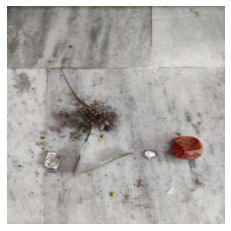

In [48]:
download_and_predict("/content/Dirty_(25).jpg")


80.51% 	 Dirty
19.49% 	 Clean


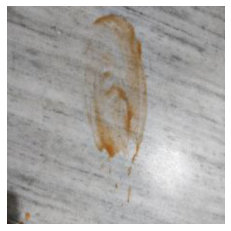

In [49]:
download_and_predict("/content/Dirty_(74).jpg")


56.16% 	 Clean
43.84% 	 Dirty


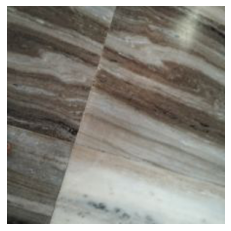

In [50]:
download_and_predict("/content/Clean_(222).jpg")


92.38% 	 Clean
7.62% 	 Dirty


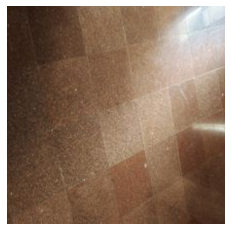

In [51]:
download_and_predict("/content/Clean_(388).jpg")


64.05% 	 Dirty
35.95% 	 Clean


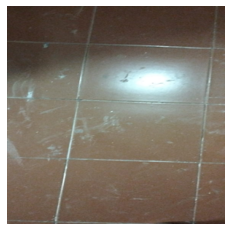

In [52]:
download_and_predict("/content/dirtys.jpg")


In [54]:
my_model.save('my_model_inception.h5', overwrite=True) 
my_model.save_weights('floor_incept_weights.h5', overwrite=True)
print("Saved model to disk")

Saved model to disk
